<center>
    <img width='80%' src='rapids_workflow.png'></center>    


<h1>RAPIDS Demo - End-To-End ML Workflow</h1>

> 0. motivate rapids [ show coverage of modern data science tools ]

> 1. generate a synthetic dataset ( with optional noise, missing data, and outliers)    
    * synthetic : sklearn.datasets
    * mini-real : mnist/fashion-mnist
    * real-dataset : uber, walmart, criteo
    
> 2. go through a supervised machine learning data science workflow
    * ingest data [ csv read ]     
    * rescale data [ standard scaler ]

> 3. model building 
    * train classifier [ xgboost ]
    * infer with trained model 

> 4. extensions 
    * create a model ensemble
    * hyper-parameter optimization


In [1]:
import pandas as pd, numpy as np, sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score

import xgboost
from xgboost import plot_tree

import cuml, cudf, numba, scipy, cupy
from numba import cuda 

import ipyvolume as ipv
import matplotlib.pyplot as plt
from fig_helpers import *
import time

# Motivation: coverage of modern data science tools

In [2]:
schemaFilePath = 'kaggle_data/schema.csv'
schemaSurveyDF = pd.read_csv(schemaFilePath)

In [3]:
scrapedKernelMethodFilePath = 'kaggle_data/results.csv'
kaggleKernelMethodsDF = pd.read_csv(scrapedKernelMethodFilePath)

In [4]:
surveyFilePath = 'kaggle_data/multipleChoiceResponses.csv'
kaggleSurveyDF = pd.read_csv(surveyFilePath, encoding="ISO-8859-1", low_memory=False)

	 At work, on average, what percentage of your time is devoted to:  
	 -  Gathering and cleaning data
	 -  Model building/model selection
	 -  Putting your work into production
	 -  Visualizing data
	 -  Finding insights in the data and communicating these to relevant stakeholders


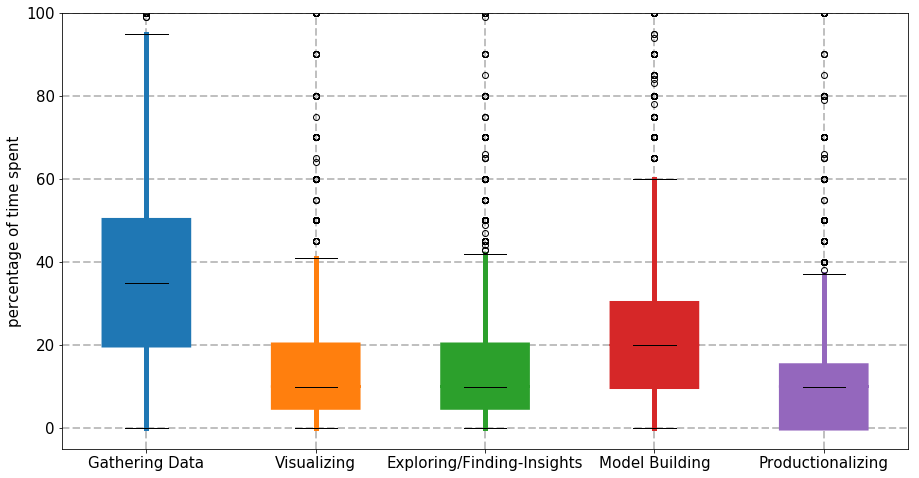

In [5]:
set_rcParams(); plot_datascientist_time_breakdown(kaggleSurveyDF, schemaSurveyDF)

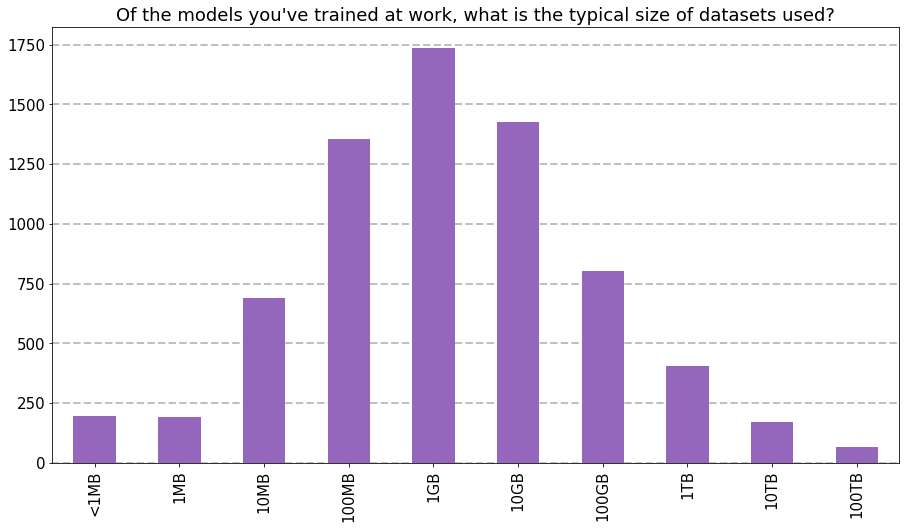

In [6]:
qNum = 119; 
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, qNum, nTopResults = 10, newIndex = ['<1MB', '1MB', '10MB', '100MB','1GB', '10GB',  '100GB', '1TB', '10TB', '100TB'])

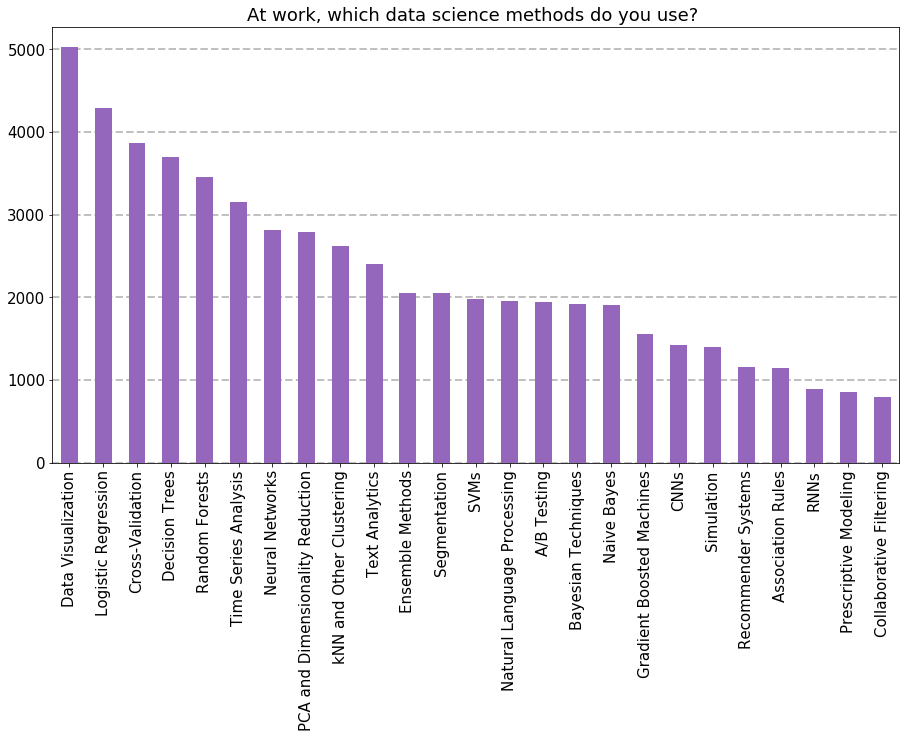

In [7]:
qNum = 180; 
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, qNum, 25)

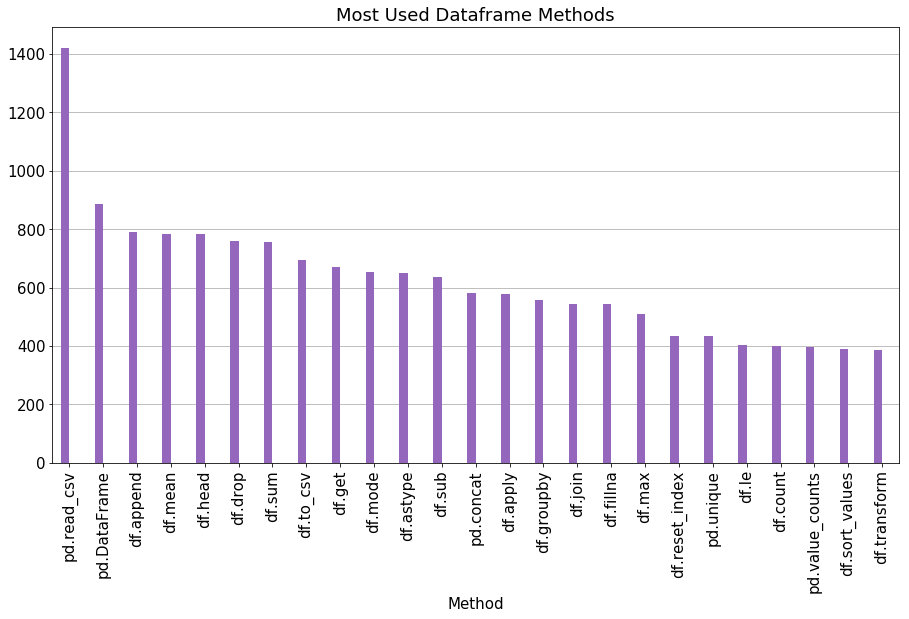

In [8]:
kaggleKernelMethodsDF.index = kaggleKernelMethodsDF['Method']
kaggleKernelMethodsDF.head(25).plot.bar(legend=False, alpha=1, color='tab:purple', rot=90); plt.gca().set_axisbelow(True); plt.gca().yaxis.grid(True)
plt.title('Most Used Dataframe Methods');

# hyperparms

In [9]:
nSamples = 1000000

# generate datasets

In [10]:
%%time
blobsDataset = datasets.make_blobs( n_samples = nSamples, 
                                    centers = 5, 
                                    n_features = 3, 
                                    cluster_std = 0.25, 
                                    random_state = 0)[0] + [0, 1.5, 0]

moonsDataset = datasets.make_moons(n_samples = nSamples, noise = 0)[0]
moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*5

swissRollDataset = datasets.make_swiss_roll( n_samples = nSamples, noise = .005)[0]

CPU times: user 9.57 s, sys: 60 ms, total: 9.63 s
Wall time: 647 ms


# augment dataset with labels of the three datasets

| <h1>dataset</h1> | <h1> class label</h1> |
| --- | --- | 
| <h3>blobs</h3> | <h3>0</h3> |
| <h3>moons</h3> | <h3>1</h3> |
| <h3>swissRoll</h3>| <h3>2</h3> |


In [11]:
blobsLabels = np.zeros(blobsDataset.shape[0])
moonsLabels = 1 * np.ones(moonsDataset.shape[0])
sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

In [12]:
X = np.vstack([blobsDataset, moonsDataset, swissRollDataset])
y = classificationLabels = np.hstack( [blobsLabels, moonsLabels, sRollLabels] )

In [13]:
X.shape, y.shape

((3000000, 3), (3000000,))

# split train (90%) and test (10%) data 

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 0, shuffle=True)

# scatterplot visualization 

In [15]:
X_train.shape, len(X_train)

((2250000, 3), 2250000)

In [16]:
def ipv_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 100000, 
                  holdOnFlag = False, markerSize=.5):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not holdOnFlag: ipv.figure()
        
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]

    ipv.scatter( data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], size = markerSize, 
                 marker = 'sphere', color = colorStack)
    
    if not holdOnFlag: ipv.show()


# visualize combined dataset

In [17]:
%time
ipv.figure()
ipv_plot_data( X_train, 'purple', 200000, True)
ipv_plot_data( X_test, 'yellow', 1000, True, 1)
ipv.show()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


## visualize sub-datasets [ moons, blobs, swiss-roll ] 
> these are concatenated together to create the full dataset, here we show them independently for clarity

In [18]:
ipv_plot_data( moonsDataset)

In [19]:
ipv_plot_data( blobsDataset )

In [20]:
ipv_plot_data( swissRollDataset )

# write dataset to disk
> so we can demonstrate ingestion

In [21]:
%%time
pd.DataFrame(data = X_train).to_csv('X_train.csv.txt', index = False)
pd.DataFrame(data = X_test).to_csv('X_test.csv.txt', index = False)
pd.DataFrame(data = y_train).to_csv('y_train.csv.txt', index = False)
pd.DataFrame(data = y_test).to_csv('y_test.csv.txt', index = False)

CPU times: user 21.4 s, sys: 232 ms, total: 21.6 s
Wall time: 21.7 s


In [22]:
!echo 'no data\n0' > warmup.csv # write a mini csv file used to initialize cuIO kernels

### check size of data on disk

In [23]:
!du -h *csv.txt

37M	X_test.csv.txt
111M	X_train.csv.txt
2.9M	y_test.csv.txt
8.6M	y_train.csv.txt


# data ingestion [ load csv ]

In [24]:
%%time 
startTime = time.time()

pd_X_train = pd.read_csv('X_train.csv.txt',  delimiter=',')
pd_X_test = pd.read_csv('X_test.csv.txt',  delimiter=',')
pd_y_train = pd.read_csv('y_train.csv.txt',  delimiter=',')
pd_y_test = pd.read_csv('y_test.csv.txt',  delimiter=',')

pandasIngestionTime = time.time() - startTime

CPU times: user 10.4 s, sys: 232 ms, total: 10.6 s
Wall time: 2.03 s


In [25]:
# get column-names
f = open('X_train.csv.txt'); colNames = f.readline().strip().split(','); f.close()
# warmup rapids data ingestion engines [ cuio kernels ]
cudf.read_csv('warmup.csv')

<cudf.DataFrame ncols=1 nrows=1 >

In [26]:
%%time
startTime = time.time()

cudf_X_train = cudf.read_csv('X_train.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_X_test = cudf.read_csv('X_test.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_y_train = cudf.read_csv('y_train.csv.txt', dtype=['float64'])
cudf_y_test = cudf.read_csv('y_test.csv.txt', dtype=['float64'])

rapidsIngestionTime = time.time() - startTime

CPU times: user 140 ms, sys: 52 ms, total: 192 ms
Wall time: 191 ms


### evaluate ingestion speedup

In [27]:
pandasIngestionTime/rapidsIngestionTime

10.643731875196535

# transform [ normalize ]
subtract mean and divide by standard deviation
> compute train stats and apply to test data

In [28]:
%%time 
startTime = time.time()

scaler = sklearn.preprocessing.StandardScaler().fit(pd_X_train) # normalize
pd_X_train = scaler.transform(pd_X_train)
pd_X_test = scaler.transform(pd_X_test)

pandasTransformTime = time.time() - startTime 

CPU times: user 1.94 s, sys: 212 ms, total: 2.15 s
Wall time: 113 ms


In [29]:
@cuda.jit 
def gpu_scale(outputCol, colGPUArrays, colMeans, colStDevs):
    iRow = cuda.grid(1)
    if iRow < colGPUArrays.size:
        outputCol[iRow] = ( colGPUArrays[iRow] - colMeans ) / ( colStDevs + 1e-10 )

In [30]:
def standard_scaler_numba( targetDF, trainMeans = None, trainStdevs = None):
    nRows = targetDF.shape[0]
    
    blockSize = 128
    blockCount = nRows // blockSize + 1
    scaledDF = cudf.DataFrame()
    
    if trainMeans is None and trainStdevs is None:
        trainMeans = {}
        trainStdevs = {}
        
    for iColName in targetDF.columns:
        colGPUArray = targetDF[iColName].to_gpu_array()
        outputCol = cuda.device_array ( shape=(nRows), dtype=colGPUArray.dtype.name)       
        if iColName not in trainMeans.keys():
            trainMeans[iColName] = targetDF[iColName].mean()
        if iColName not in trainStdevs.keys():
            trainStdevs[iColName] = targetDF[iColName].std()
        gpu_scale[(blockCount),(blockSize)](outputCol, colGPUArray, trainMeans[iColName], trainStdevs[iColName])
        scaledDF.add_column(name=iColName, data = outputCol)    
        
    return scaledDF, trainMeans, trainStdevs

In [31]:
_, _, _ = standard_scaler_numba( cudf_X_test.copy().head(2) ) # warmup

In [32]:
%%time
startTime = time.time()

cudf_X_train, trainMeans, trainStdevs = standard_scaler_numba( cudf_X_train )
cudf_X_test, _, _ = standard_scaler_numba( cudf_X_test, trainMeans, trainStdevs )

rapidsTransformTime = time.time() - startTime

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 30.7 ms


### evaluate transform speedup
note that for the default dataset size of 100,000 pandas[on CPU] may be faster

to see a more representative performance gain for rapids try changing the nSamples to 1 million or more

> !changing nSamples to 1m will cause very slow plotting, so consider skiping plot calls when doing this test

In [33]:
pandasTransformTime/rapidsTransformTime

3.6893900523967225

# verify numerical equivalence (approximate)

In [34]:
trainMeans, scaler.mean_, trainStdevs, scaler.scale_

({'0': 1.4832920191964376, '1': 6.08058386618916, '2': 0.48279021433241337},
 array([1.48174369, 6.08053774, 0.48276985]),
 {'0': 4.777875329597415, '1': 5.738559147864635, '2': 5.235193221845326},
 array([4.77732552, 5.73850006, 5.23516884]))

In [35]:
print(pd_X_test[0:2,:])

[[ 0.63863771 -0.69181658 -0.09221667]
 [ 2.26421471 -0.72046155  0.62701107]]


In [36]:
print(cudf_X_test.head(2))

                   0                   1                    2
0 0.6382401589308468 -0.6918175007116459 -0.09222013283265505
1 2.2636300971292136 -0.7204621685542189    0.627004255026338


-----
# model training -- xgboost
-----
>XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target).

<img src='xgboost.png' width =90%>

## prepare data for training

In [37]:
X = pd_X_train
y = pd_y_train

In [38]:
X_gpu = xgboost.DMatrix(pd_X_train, label=np.squeeze(pd_y_train), 
                        feature_names=["f0", "f1", "f2"],
                        feature_types=['float']*3)
y_gpu = xgboost.DMatrix(pd_X_test, label=np.squeeze(pd_y_test))

### specify parameters

noteable parameters: [ to see all available options execute '?xgboost.XGBClassifier' in a new cell] 

* __max_depth__ : int [ default = 3 ] -- Maximum tree depth for base learners.
* __n_estimators__ : int [ default = 100 ] -- Number of boosted trees to fit.
* __n_jobs__ : int [ default = 1 ] -- Number of parallel threads used to run xgboost.

In [39]:
cpuMaxDepth = 3 # default
nTrees = 100 # default

gpuMaxDepth = 10

nCores = !nproc --all
nCores = int(nCores[0])

paramsGPU = {
    'max_depth': gpuMaxDepth,
    'n_estimators': nTrees,
    'n_gpus': 1,
    'tree_method': 'gpu_hist',
    'objective': 'gpu:reg:linear', 
    'random_state': 0,
    'verbose_model': True
}
paramsCPU = {
    'max_depth': cpuMaxDepth,
    'n_estimators': nTrees,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'n_jobs': nCores
}

## train on cpu

In [40]:
xgBoostModelCPU = xgboost.XGBClassifier(max_depth = paramsCPU['max_depth'], 
                                        n_estimators = paramsCPU['n_estimators'],
                                        tree_method = paramsCPU['tree_method'],
                                        objective = paramsCPU['objective'],                                        
                                        n_jobs = paramsCPU['n_jobs'])

In [41]:
xgBoostModelCPU, print("using {} CPU cores for parallel xgboost training".format(nCores))

using 40 CPU cores for parallel xgboost training


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=40, nthread=None, objective='binary:logistic',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=True, subsample=1, tree_method='hist'), None)

In [42]:
%%time
startTime = time.time()

xgBoostModelCPU.fit( X, np.squeeze(y) );

cpuXGBoostTime = time.time() - startTime

[17:58:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
CPU times: user 9min 9s, sys: 344 ms, total: 9min 9s
Wall time: 14.2 s


## train on GPU

In [43]:
%%time
startTime = time.time()

xgBoostModelGPU = xgboost.train( dtrain = X_gpu, params = paramsGPU)

gpuXGBoostTime = time.time() - startTime

CPU times: user 6.97 s, sys: 88 ms, total: 7.06 s
Wall time: 333 ms


## evaluate model training speedup

In [44]:
cpuXGBoostTime/gpuXGBoostTime

42.613220981738934

-----------

# model inference 

# infer/predict using trained [CPU ] model

In [45]:
%%time
startTime = time.time()

yPredTrain = xgBoostModelCPU.predict(pd_X_train)
yPredTest = xgBoostModelCPU.predict(pd_X_test)

cpuXGBoostInferenceTime = time.time() - startTime

CPU times: user 59.9 s, sys: 132 ms, total: 1min
Wall time: 1.58 s


## infer/predict using trained [GPU ] model
> note that our objective was changed to a regression [ gpu accelerated ] so we must take care to convert each of our predictions from a continuous value to a discrete class (essentially by rounding).

In [46]:
# convert continuous prediction to a multi-class option
def continuous_to_discrete( data, nClasses = 3):
    data[data>nClasses-1] = nClasses-1 # filter values beyond the possible classes
    return np.abs(np.round(data))

In [47]:
%%time
startTime = time.time()

yPredTrain_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(X_gpu) )
yPredTest_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(y_gpu) )

gpuXGBoostInferenceTime = time.time() - startTime

CPU times: user 708 ms, sys: 0 ns, total: 708 ms
Wall time: 17.8 ms


## evaluate model inference speedup

In [48]:
cpuXGBoostInferenceTime/gpuXGBoostInferenceTime

88.67489805773151

# evaluate accuracy

In [49]:
print( 'CPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTest) ))
print( 'GPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTest_GPU) ))

CPU test accuracy: 0.999888 
GPU test accuracy: 0.999921 


TODO: to increase model accuracy, increase complexity, number of trees, max_depth


In [50]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest))


 confusion matrix on TRAIN data -- 
[[749932      0    160]
 [     0 750434      0]
 [     0     83 749391]]

 confusion matrix on TEST data -- 
[[249854      0     54]
 [     0 249566      0]
 [     0     30 250496]]


In [51]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain_GPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest_GPU))


 confusion matrix on TRAIN data -- 
[[750021     66      5]
 [     0 750434      0]
 [     2     43 749429]]

 confusion matrix on TEST data -- 
[[249879     22      7]
 [     0 249566      0]
 [     3     27 250496]]


# visualizing a CPU boosted tree

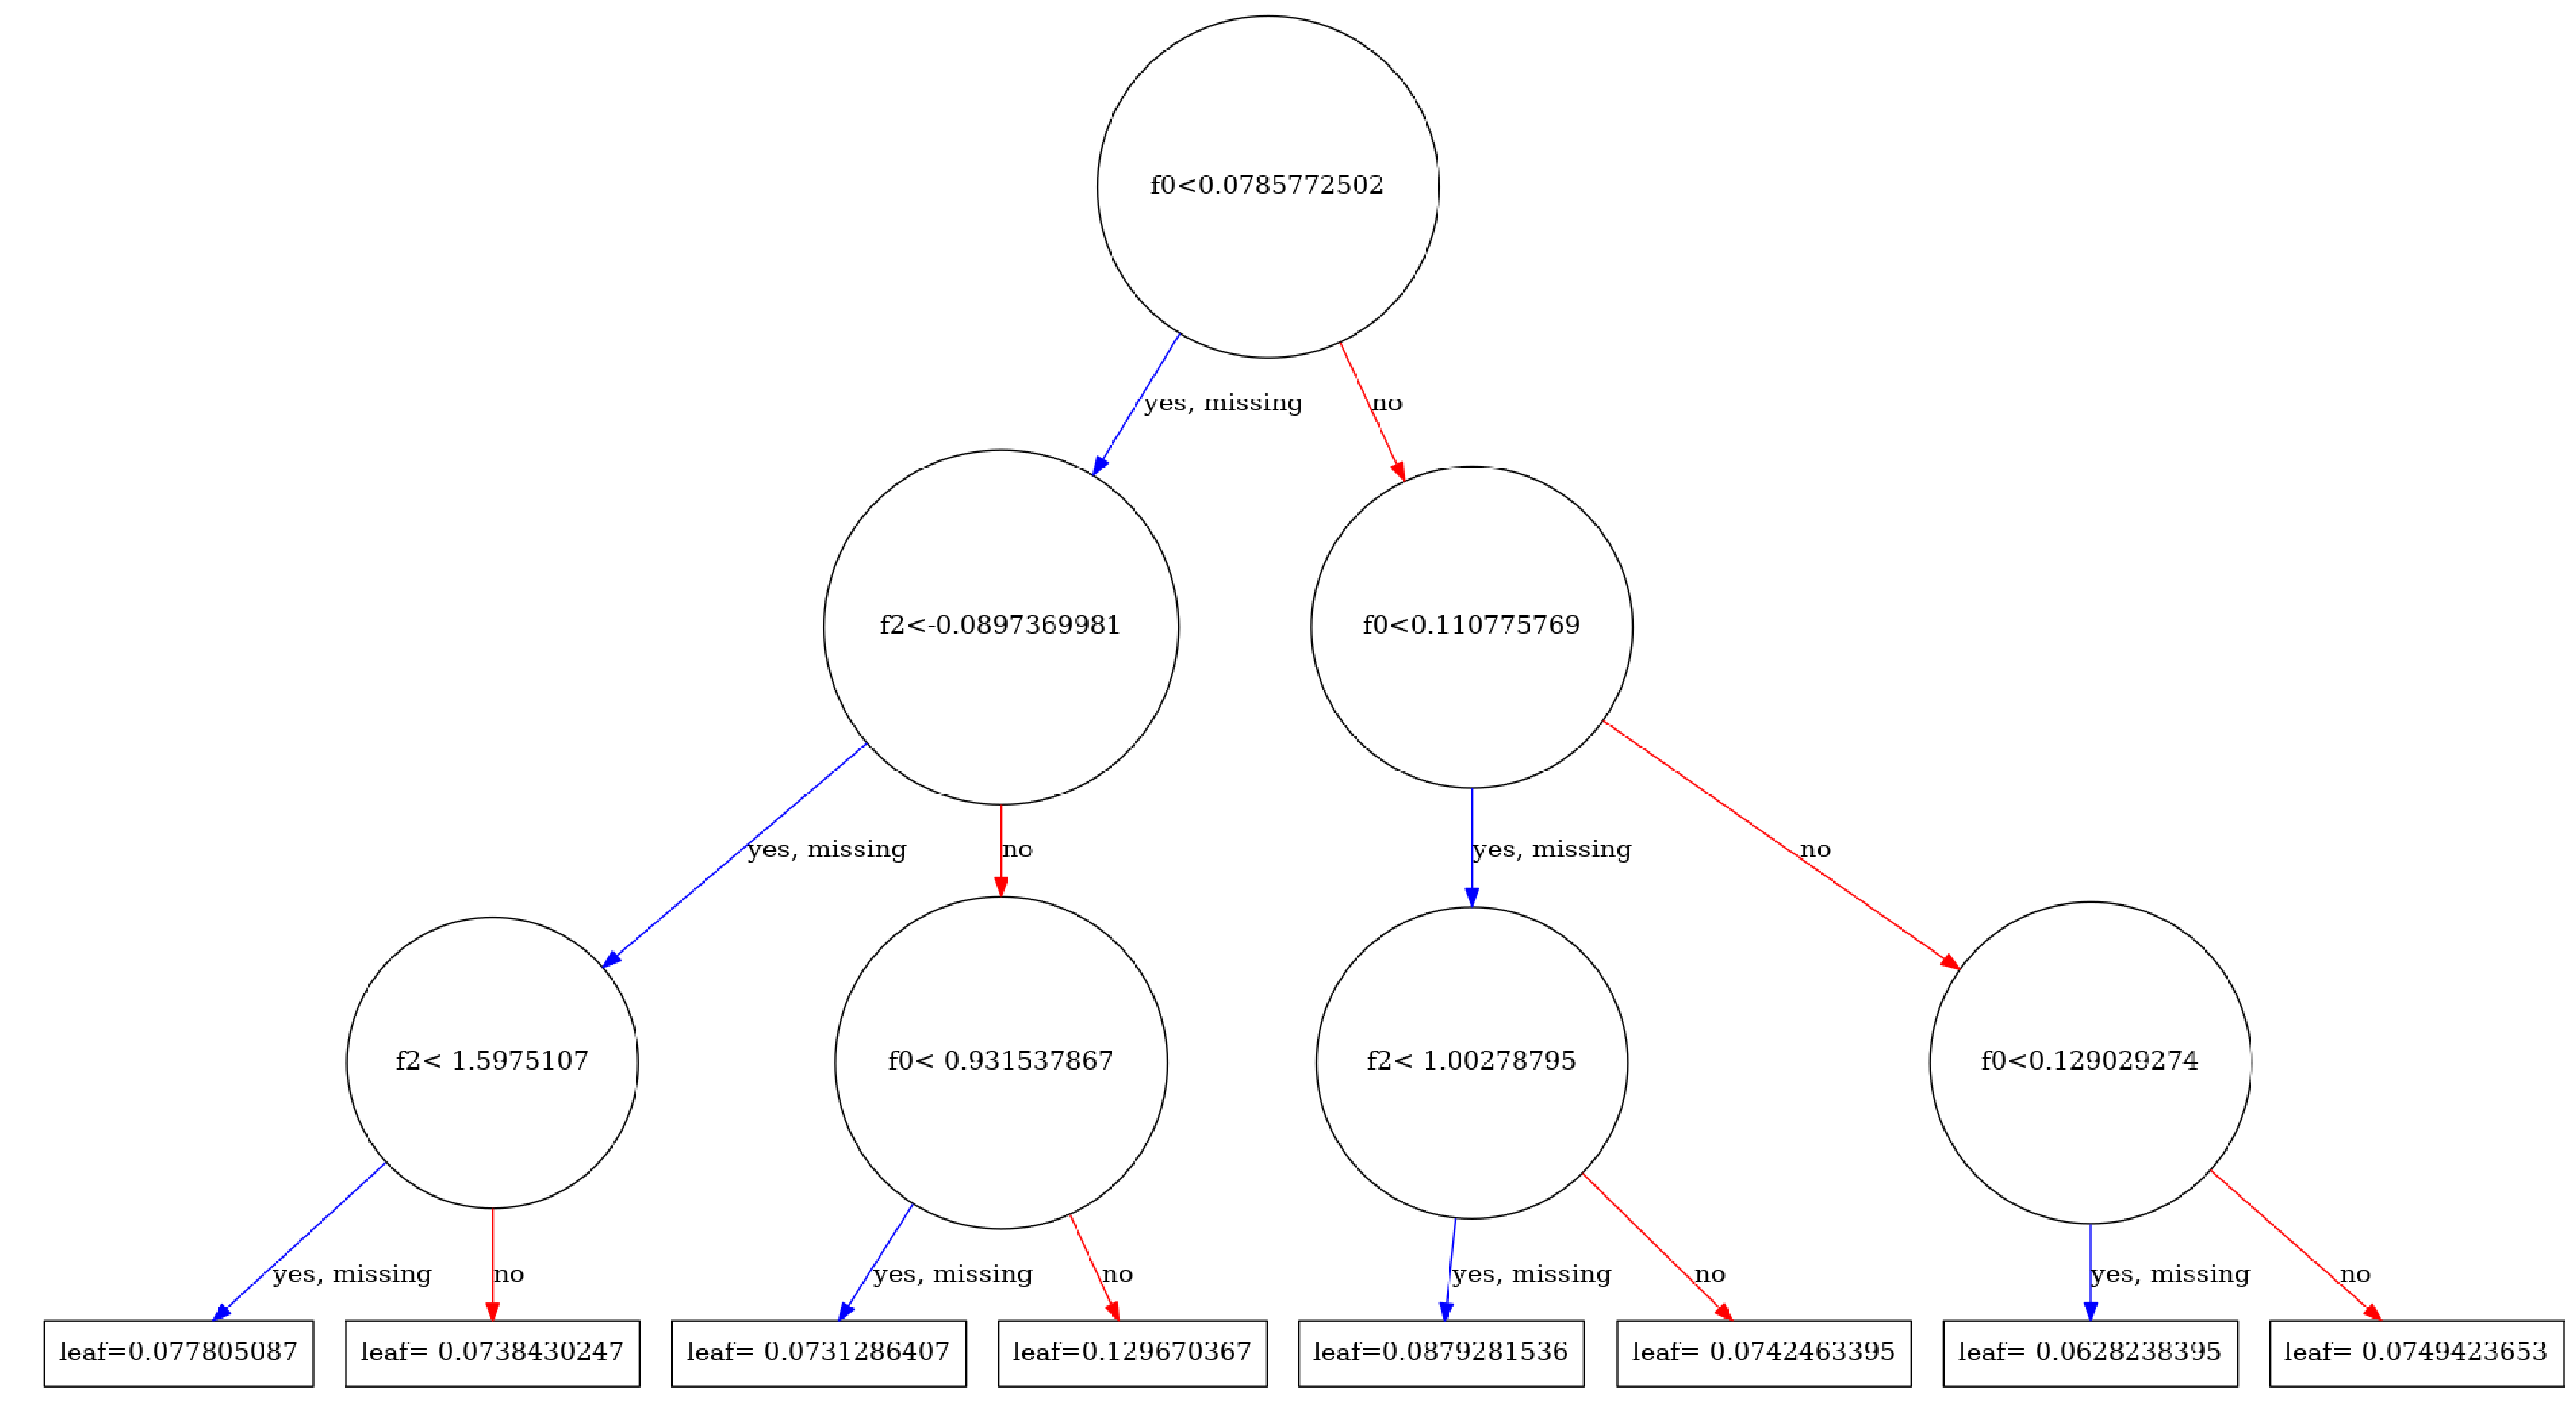

In [52]:
fig = plt.figure(figsize=(50,50))
plot_tree(xgBoostModelCPU, num_trees=0, ax=plt.subplot(1,1,1))

# visualizing a GPU boosted tree

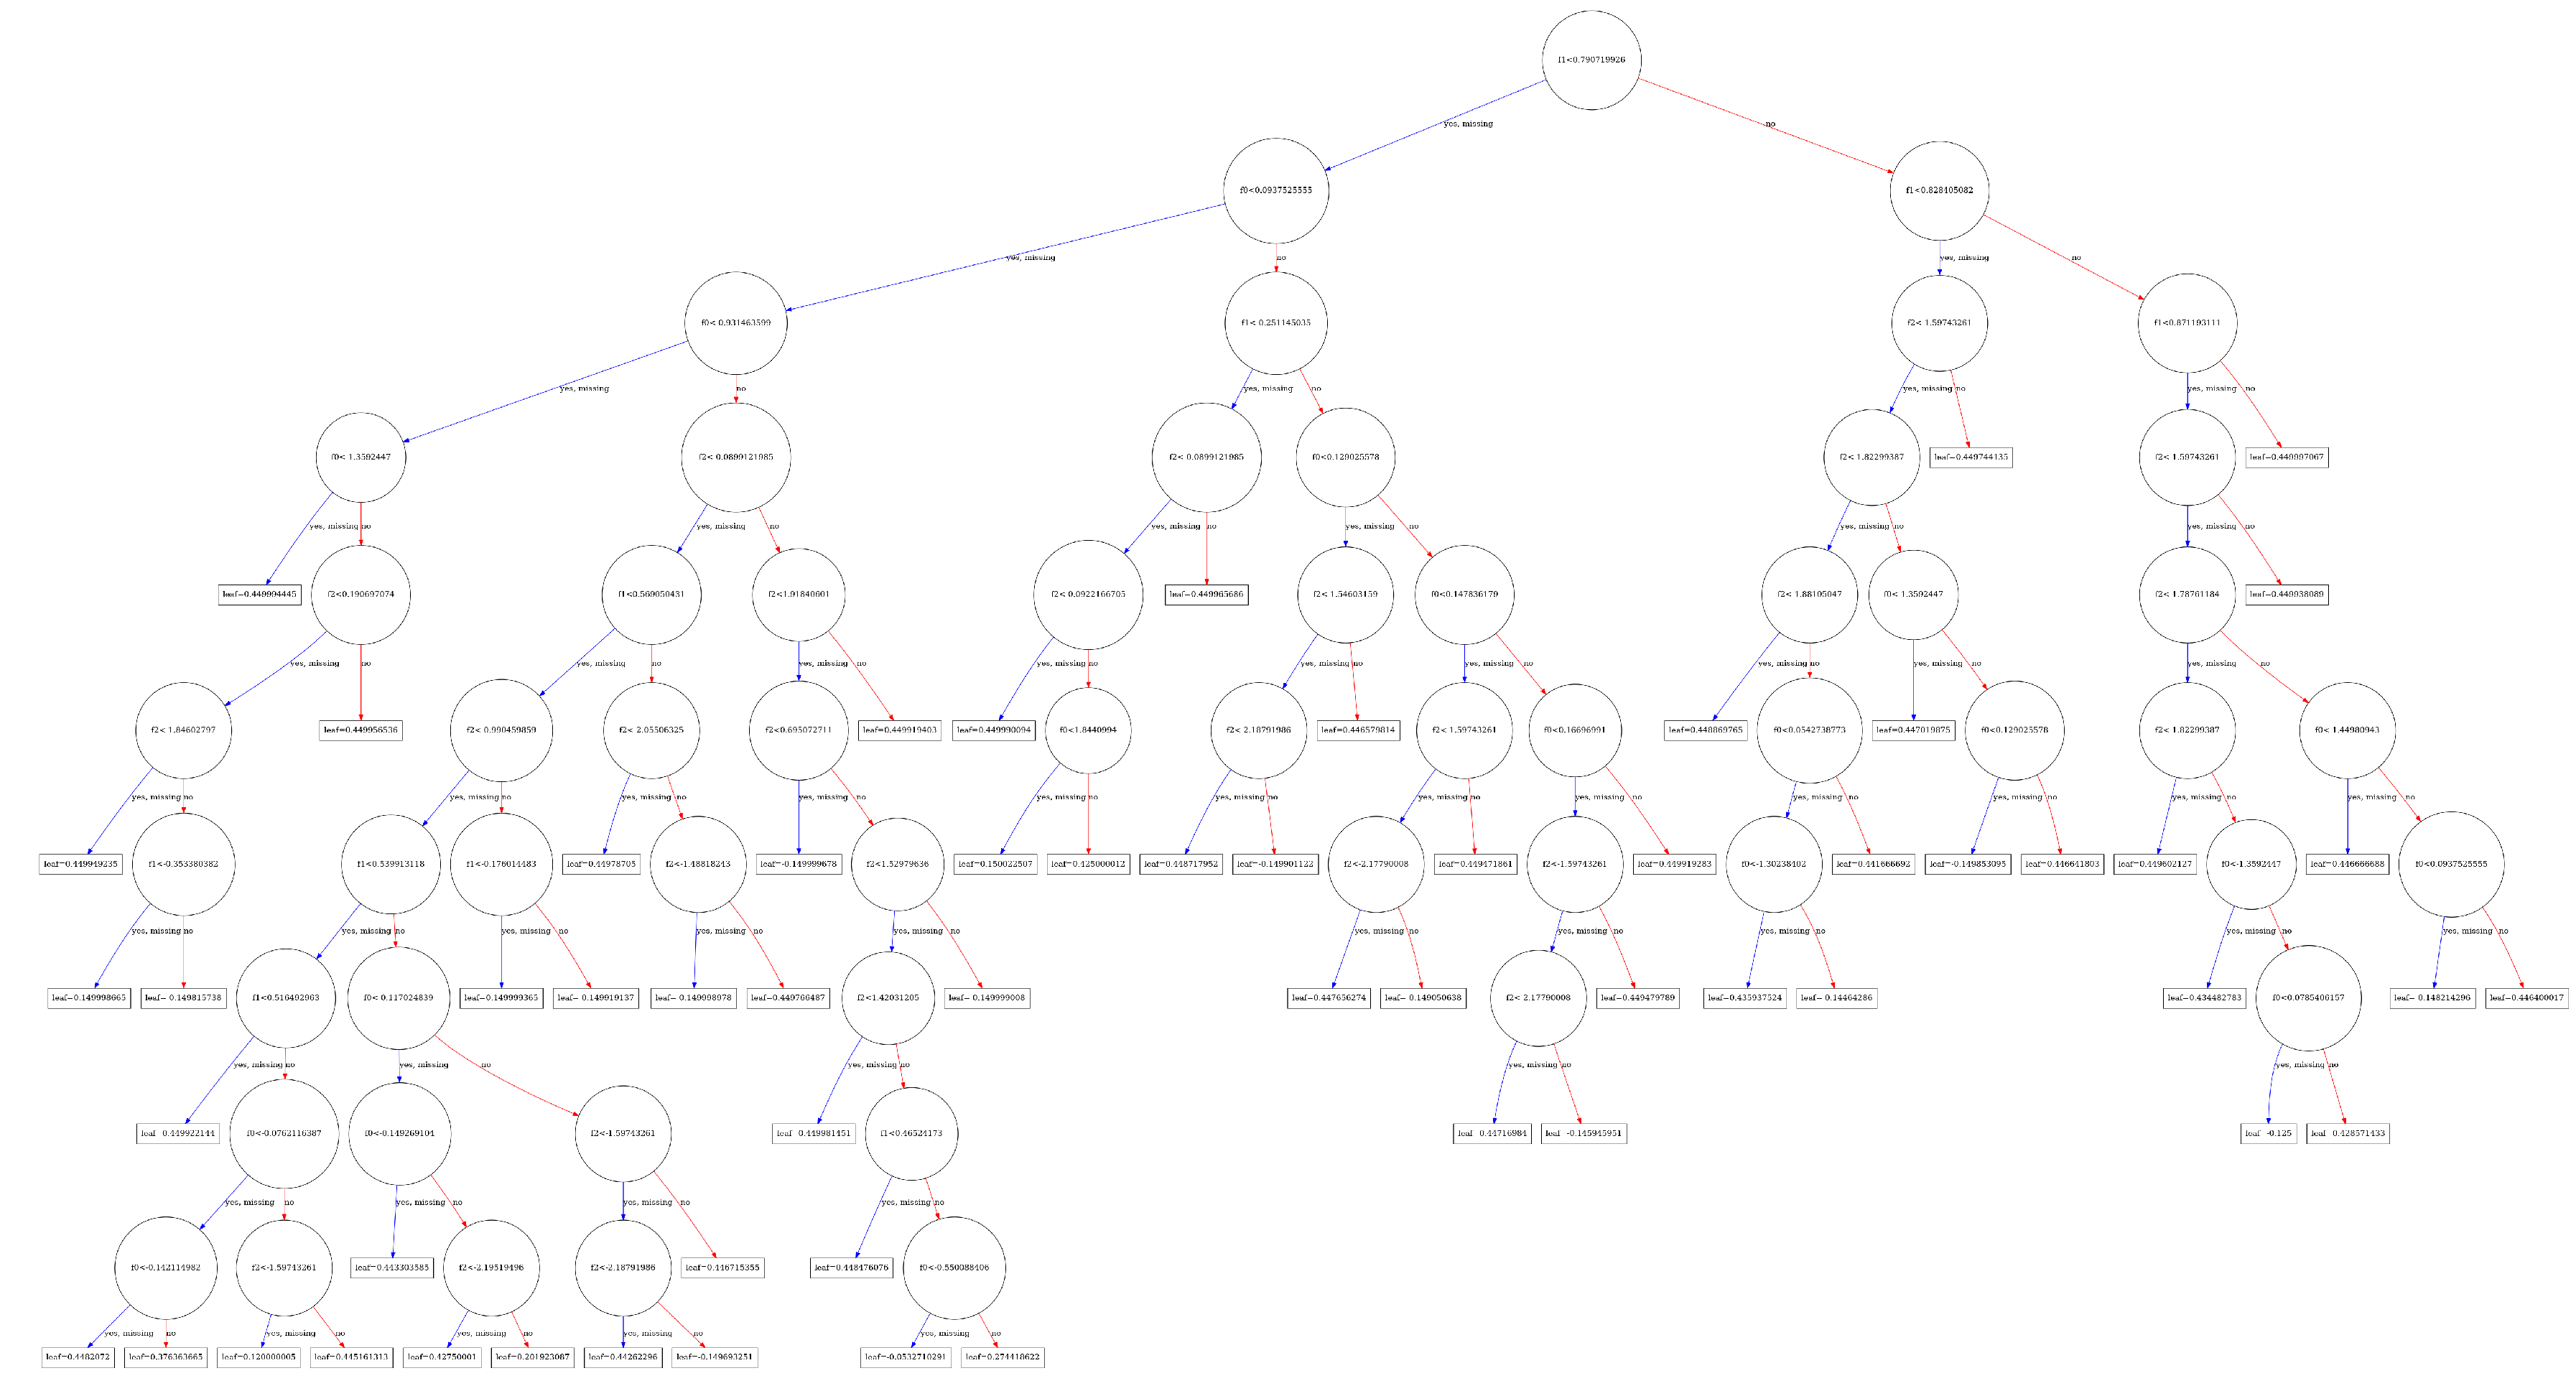

In [53]:
fig = plt.figure(figsize=(50,50))
plot_tree(xgBoostModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

## visualize predictions

In [54]:
def map_colors_to_clusters_topK ( dataset, labels, topK=None, cmapName = 'tab10'):
    if topK == None:
        topK = dataset.shape[0]
    
    colorStack = np.zeros((topK, 3), dtype=np.float32)
    
    cMap = plt.get_cmap(cmapName)
    for iColor in range ( topK ):
        colorStack[iColor] = cMap.colors[ labels[iColor] ]
        
    return colorStack    

In [55]:
def colored_topK ( dataset, topK = None):    
    if topK == None:
        topK == dataset.shape[0]
        
    return lambda dataset, colorStack, topK : ipv.quickscatter( dataset[0:topK, 0], 
                                                                dataset[0:topK, 1], 
                                                                dataset[0:topK, 2], 
                                                                size = .5, marker = 'sphere', 
                                                                color = colorStack)      

In [77]:
colorStackClassifier = map_colors_to_clusters_topK ( pd_X_test, yPredTest_GPU.astype(np.int), topK=None )

In [79]:
colorStackClassifier.shape

(750000, 3)

In [78]:
ipv_plot_data( pd_X_test, colorStack= colorStackClassifier)

-------
# extensions
-------

# extension 1 : model ensemble ( xgboost + clustering )

<img width='95%' src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png'>

### sklearn-clustering

In [70]:
# sub-sample
nSamplesToCluster = 30000
pd_X_test_sampled = pd_X_test[:nSamplesToCluster, :]  
cudf_X_test_sampled = cudf_X_test.loc[0:nSamplesToCluster,list(cudf_X_test.columns)]

In [71]:
%%time
startTime = time.time()

dbScanModel = DBSCAN( min_samples = 10, n_jobs = nCores ).fit(pd_X_test_sampled)
labels = dbScanModel.labels_

sklearnDBScanTime = time.time() - startTime

CPU times: user 28.6 s, sys: 152 ms, total: 28.7 s
Wall time: 1.46 s


### cuml-clustering

In [72]:
%%time
startTime = time.time()

clustering_cuml = cuml.DBSCAN( eps = .15 , min_samples = 200 )
clustering_cuml.fit( cudf_X_test_sampled )

rapidsDBScanTime = time.time() - startTime

n_rows: 30001
0x7f26e9845000
CPU times: user 480 ms, sys: 168 ms, total: 648 ms
Wall time: 646 ms


In [73]:
%%time
print( clustering_cuml.labels_.value_counts() )

       
3 11916
4  4986
0  4960
6  2051
5  2029
1  2021
2  2015
-1    23
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.6 ms


## evaluate clustering speedup

In [74]:
sklearnDBScanTime/rapidsDBScanTime

2.259514354226755

# map clusters to colors

In [75]:
%%time
colorStack = map_colors_to_clusters_topK( pd_X_test, clustering_cuml.labels_, nSamplesToCluster  )

CPU times: user 3.65 s, sys: 28 ms, total: 3.68 s
Wall time: 3.68 s


# plot colored clusters

In [76]:
colored_topK( pd_X_test_sampled, nSamplesToCluster )(pd_X_test_sampled, colorStack, nSamplesToCluster)

# [ TODO ] extension 2 : hyper-parameter search

# end [ thanks! ]

please provide feedback/suggestions and errata @ https://github.com/miroenev/rapids